## **Fine-Tuning Embedding Models for Tabular RAG**
*By Cristian Leo*

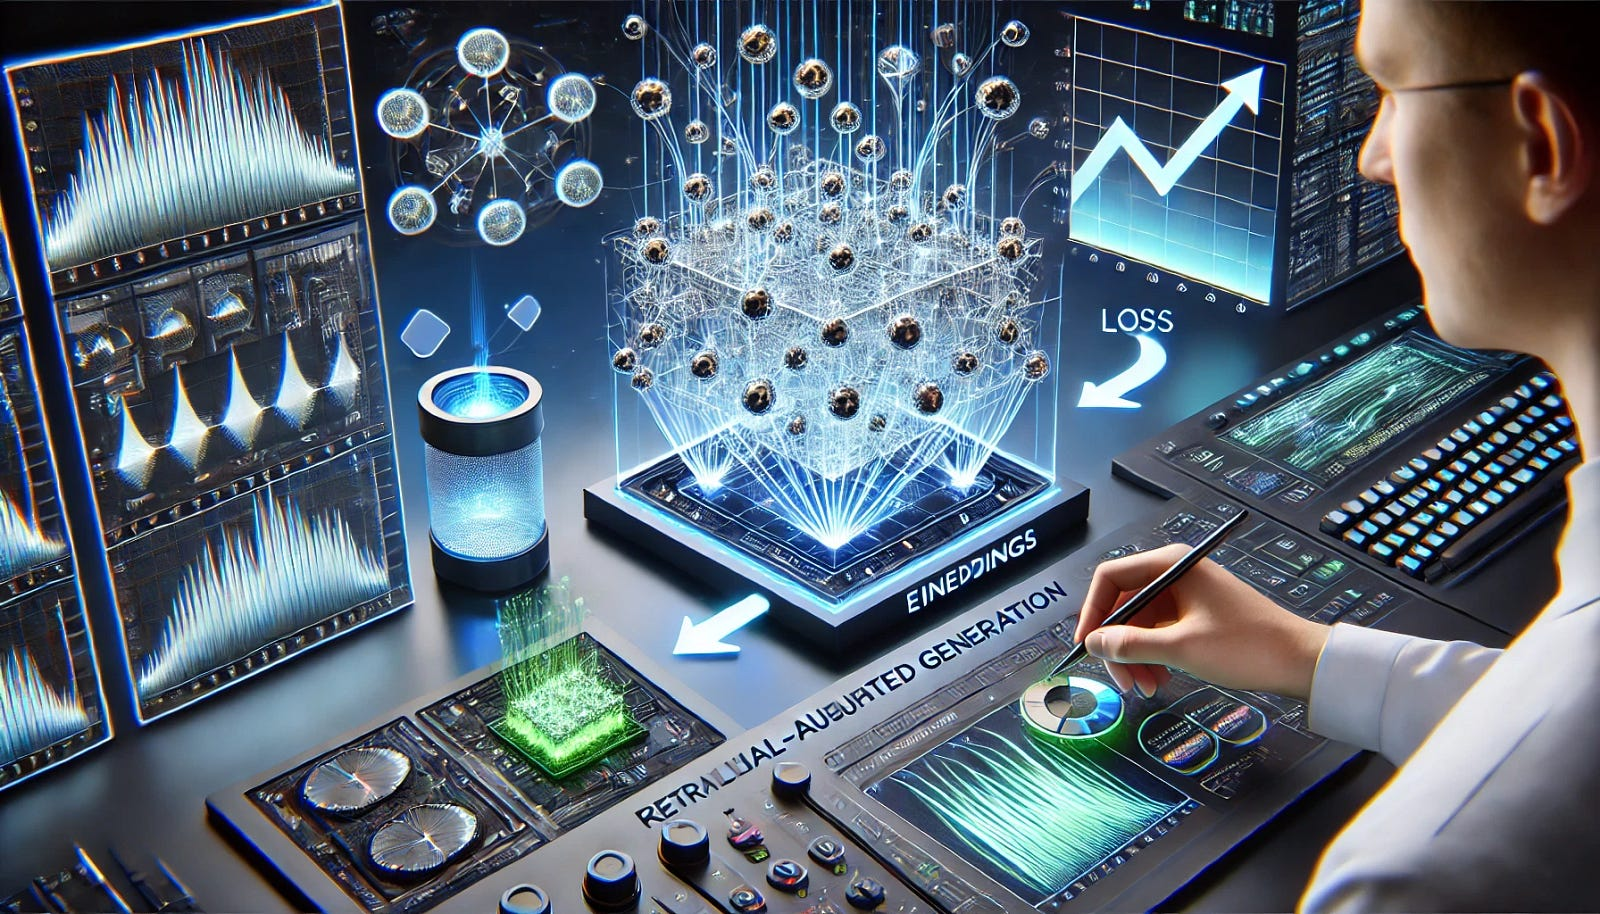

In [1]:
# Standard library imports
import logging
import os
import pickle
import re
import time
from dataclasses import dataclass, field
from typing import Any, Dict, List, Union

# Data science and ML libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import yfinance as yf
from sentence_transformers import InputExample, SentenceTransformer, losses
import faiss
from sklearn.metrics.pairwise import cosine_similarity

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# LangChain related
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain.prompts import PromptTemplate

# Other third-party libraries
from dotenv import load_dotenv
from tqdm import tqdm

load_dotenv()

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

load_dotenv()

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

/Users/cristianleo/Documents/Documents - Cristian’s Laptop/GitHub/models-from-scratch-python/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ---------------------------
# 1. Configuration Classes
# ---------------------------
@dataclass
class Config:
    tickers: List[str] = field(
        default_factory=lambda: ["AAPL", "GOOGL", "MSFT", "AMZN", "META"]
    )
    embedding_model: str = "all-MiniLM-L6-v2"
    top_k: int = 1

In [3]:
# ---------------------------
# 2. Data Loading: Quarterly Balance Sheets
# ---------------------------
class FinancialDataLoader:
    """
    Class to load financial data from Yahoo Finance

    Args:
    -----
    config: Config
        Configuration object with the desired tickers
    """
    def __init__(self, config: Config):
        self.config = config
        self.logger = logging.getLogger(__name__)

    def load_quarterly_balance_sheets(self) -> Dict[str, pd.DataFrame]:
        """
        Load quarterly balance sheets for the specified tickers

        Returns:
        --------
        Dict[str, pd.DataFrame]
            Dictionary with the quarterly balance sheets for each ticker
        """
        balance_sheets = {}
        for ticker in tqdm(
            self.config.tickers, desc="Loading quarterly balance sheets"
        ):
            try:
                stock = yf.Ticker(ticker)
                # Using the quarterly balance sheet property from yfinance
                bs = stock.quarterly_balance_sheet
                bs.dropna(axis=1, thresh=0.5, inplace=True)
                bs.dropna(axis=0, thresh=0.5, inplace=True)
                if bs is not None and not bs.empty:
                    # (Transpose so that each row is one quarter if desired)
                    balance_sheets[ticker] = bs.T
                    self.logger.info(
                        f"Successfully loaded quarterly balance sheet for {ticker}"
                    )
            except Exception as e:
                self.logger.error(
                    f"Error loading quarterly balance sheet for {ticker}: {e}"
                )
        return balance_sheets

In [4]:
# ---------------------------
# 3. Financial Chunker & Balance Sheet Visualization
# ---------------------------
class FinancialChunker:
    """
    Class to create text chunks from financial data

    Args:
    -----
    model_name: str
        Name of the SentenceTransformer model to use
    """
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.embedder = SentenceTransformer(model_name)

    def create_chunks(self, balance_sheets: Dict[str, pd.DataFrame]) -> List[str]:
        """
        For each ticker and for each quarter in its balance sheet, create a text chunk.

        Args:
        -----
        balance_sheets: Dict[str, pd.DataFrame]
            Dictionary with the quarterly balance sheets for each ticker
        
        Returns:
        --------
        List[str]
            List of text chunks
        """
        chunks = []
        for ticker, df in balance_sheets.items():
            # Each row corresponds to one quarter (with the date as index)
            for date, row in df.iterrows():
                # Select a few key metrics if available (or iterate over all)
                total_assets = row.get("Total Assets", None)
                total_liabilities = row.get("Total Liab", None) or row.get(
                    "Total Liabilities", None
                )
                total_equity = row.get("Total Stockholder Equity", None) or row.get(
                    "Total Equity", None
                )

                # Build a summary text for the quarter.
                text = f"{ticker} Balance Sheet as of {date.strftime('%Y-%m-%d')}:\n"
                if total_assets is not None:
                    text += f"- Total Assets: {total_assets:,.0f}\n"
                if total_liabilities is not None:
                    text += f"- Total Liabilities: {total_liabilities:,.0f}\n"
                if total_equity is not None:
                    text += f"- Total Equity: {total_equity:,.0f}\n"
                # Optionally include additional metrics
                for metric, value in row.items():
                    if metric not in [
                        "Total Assets",
                        "Total Liab",
                        "Total Liabilities",
                        "Total Stockholder Equity",
                        "Total Equity",
                    ]:
                        text += f"- {metric}: {value}\n"
                chunks.append(text)
        return chunks

In [5]:
# ---------------------------
# 4. Vector Store & RAG System
# ---------------------------
class VectorStore:
    """
    Class to create a vector store and search for similar vectors

    Args:
    -----
    config: Config
        Configuration object with the desired embedding model
    """
    def __init__(self, config: Config):
        self.config = config
        self.model = SentenceTransformer(config.embedding_model)
        self.index = None
        self.chunks = []

    def create_index(self, chunks: List[str]) -> None:
        """
        Create a Faiss index for the embeddings of the text chunks

        Args:
        -----
        chunks: List[str]
            List of text chunks
        """
        embeddings = self.model.encode(chunks)
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(np.array(embeddings).astype("float32"))
        self.chunks = chunks

    def search(self, query: str) -> List[str]:
        """
        Search for similar text chunks given a query

        Args:
        -----
        query: str
            Query text
        
        Returns:
        --------
        List[str]
            List of similar text chunks
        """
        query_embedding = self.model.encode([query])
        D, I = self.index.search(
            np.array(query_embedding).astype("float32"), self.config.top_k
        )
        return [self.chunks[i] for i in I[0]]
    
class FinancialRAG:
    """
    Class to initialize and query the RAG system

    Args:
    -----
    config: Config
        Configuration object with the desired settings
    """
    def __init__(self, config: Config):
        self.config = config
        self.loader = FinancialDataLoader(self.config)
        self.chunker = FinancialChunker(model_name=self.config.embedding_model)
        self.vector_store = VectorStore(self.config)
        self.logger = logging.getLogger(__name__)

    def initialize(self):
        """
        Initialize the RAG system by loading financial data, creating text chunks and building the vector store
        """
        balance_sheets = self.loader.load_quarterly_balance_sheets()
        chunks = self.chunker.create_chunks(balance_sheets)
        self.vector_store.create_index(chunks)
        self.logger.info("RAG system initialized successfully")

    def query(self, question: str) -> List[str]:
        """
        Query the RAG system with a question

        Args:
        -----
        question: str
            Question text
        
        Returns:
        --------
        List[str]
            List of similar text chunks
        """
        return self.vector_store.search(question)

In [6]:
# ---------------------------
# 5. Fine-Tuning the Embedding Model using Quarterly Balance Sheets
# ---------------------------
@dataclass
class TrainConfig:
    tickers: List[str] = field(
        default_factory=lambda: ["AAPL", "GOOGL", "MSFT", "AMZN", "META"]
    )
    epochs: int = 1000
    batch_size: int = 16
    learning_rate: float = 2e-5
    epsilon: float = 1e-6
    scheduler: str = "WarmupLinear"
    optimizer_class: Any = torch.optim.AdamW
    model_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    model_output_dir: str = "fine-tuned-embedding-model"


def generate_questions(context: str) -> str:
    """
    Uses LangChain's Gemini to generate a set of insightful questions
    for a given quarterly balance sheet summary.

    Args:
    -----
    context: str
        The quarterly balance sheet summary

    Returns:
    --------
    str
        The generated question
    """
    rate_limiter = InMemoryRateLimiter(requests_per_second=0.1)

    llm = GoogleGenerativeAI(
        model="gemini-1.5-flash",
        api_key=os.getenv("GOOGLE_API_KEY"),
        rate_limiter=rate_limiter,
    )

    prompt = PromptTemplate(
        template="Generate one insightful question targeted for retrieval purposes about the following quarterly balance sheet summary:\n\n{context}\n\nQuestions:",
        input_variables=["context"],
    )
    chain = prompt | llm
    response = chain.invoke({"context": context})

    # Use regex to extract only the final question if any extra text exists.
    match = re.search(
        r"(?:Final Question:)(.*)", response, flags=re.IGNORECASE | re.DOTALL
    )
    if match:
        question = match.group(1).strip()
    else:
        question = response.strip()

    # remove any stray chain-of-thought markers.
    question = re.sub(r"<think>.*?</think>", "", question, flags=re.DOTALL).strip()
    return question

In [7]:
# ---------------------------
# 6. Model Training & Evaluation
# ---------------------------
class FinancialDataset:
    """
    Creates training examples using the balance sheet chunks generated by the chunker.
    For each chunk, a set of questions is generated using LangChain Ollama.
    A fraction of the generated examples is held out as a test dataset.
    """

    def __init__(
        self, balance_sheets: Dict[str, pd.DataFrame], chunker: FinancialChunker
    ):
        self.examples = []  # Training examples

        # check if pickle file exists
        if os.path.exists("qa_pairs.pkl"):
            print("Loading examples from pickle file")
            self.load_examples()
        else:
            self._create_examples(balance_sheets, chunker)

    def _create_examples(
        self, balance_sheets: List[dict], chunker: FinancialChunker
    ) -> None:
        """
        Create training and test examples from balance sheets.

        Args:
            balance_sheets: List of balance sheet dictionaries
            chunker: Chunker instance to split text
        """
        logging.info(f"Creating examples from {len(balance_sheets)} balance sheets")

        # Create chunks
        chunks = chunker.create_chunks(balance_sheets)
        all_examples: List[InputExample] = []

        # Generate questions for each chunk with progress bar
        for chunk in tqdm(
            chunks, desc="Generating questions", unit="chunk", leave=True, position=0
        ):
            try:
                question = generate_questions(chunk)
                time.sleep(3)  # Rate limit to avoid API restrictions
                all_examples.append(InputExample(texts=[chunk, question]))
            except Exception as e:
                logging.error(f"Failed to generate question for chunk: {e}")
                continue

        self.examples = all_examples

        logging.info(f"Created {len(self.examples)} examples")

    # save examples as pickle
    def save_examples(self):
        with open("qa_pairs.pkl", "wb") as f:
            pickle.dump(self.examples, f)

    # load examples from pickle
    def load_examples(self):
        with open("qa_pairs.pkl", "rb") as f:
            self.examples = pickle.load(f)

In [8]:
# ---------------------------
# 7. Model Training
# ---------------------------
class ModelTrainer:
    """
    Class to train a SentenceTransformer model on financial data

    Args:
    -----
    config: TrainConfig
        Configuration object with the desired settings
    """
    def __init__(self, config: TrainConfig):
        self.config = config
        self.model = None
        self.model_output_dir = self.config.model_output_dir
        self.logger = logging.getLogger(__name__)

    def model_exists(self):
        return os.path.exists(self.model_output_dir)

    def load_model(self):
        if self.model_exists():
            self.model = SentenceTransformer(self.model_output_dir)
            self.logger.info(f"Loaded fine-tuned model from {self.model_output_dir}")
            return self.model
        return None

    def save_model(self):
        if self.model:
            self.model.save(self.model_output_dir)
            self.logger.info(f"Saved fine-tuned model to {self.model_output_dir}")

    def train(self, balance_sheets: Dict[str, pd.DataFrame]) -> SentenceTransformer:
        """
        Train a SentenceTransformer model on financial data
        
        Args:
        -----
        balance_sheets: Dict[str, pd.DataFrame]
            Dictionary with the quarterly balance sheets for each ticker
        
        Returns:
        --------
        SentenceTransformer
            Trained SentenceTransformer model
        """
        if self.load_model():
            self.model = self.model
        else:
            self.model = SentenceTransformer(self.config.model_name)

        dataset = FinancialDataset(balance_sheets, FinancialChunker())
        dataloader = DataLoader(
            dataset.examples, batch_size=self.config.batch_size, shuffle=False
        )
        loss = losses.MultipleNegativesRankingLoss(self.model)

        self.model.fit(
            train_objectives=[(dataloader, loss)],
            epochs=self.config.epochs,
            scheduler=self.config.scheduler,
            optimizer_class=self.config.optimizer_class,
            optimizer_params={
                "lr": self.config.learning_rate,
                "eps": self.config.epsilon,
            },
            show_progress_bar=True,
        )

        self.save_model()
        return self.model

In [9]:
# ---------------------------
# 8. Model Evaluation
# ---------------------------
@dataclass
class EvaluationResult:
    query: str
    pre_contexts: List[str]
    post_contexts: List[str]
    pre_similarity: float
    post_similarity: float
    improvement: float


class EmbeddingEvaluator:
    """
    Class to evaluate the performance of the fine-tuned embedding model

    Args:
    -----
    rag_pre: FinancialRAG
        RAG system with the pre-trained model
    rag_post: FinancialRAG
        RAG system with the fine-tuned model
    queries: List[str]
        List of queries to evaluate
    """
    def __init__(
        self, rag_pre: FinancialRAG, rag_post: FinancialRAG, queries: List[Any]
    ):
        self.rag_pre = rag_pre
        self.rag_post = rag_post
        self.test_queries = queries
        self.results = []

    def evaluate(self) -> List[EvaluationResult]:
        """
        Evaluate the performance of the fine-tuned model

        Returns:
        --------
        List[EvaluationResult]
            List of evaluation results
        """
        for query in self.test_queries:
            query = query.texts[1]
            pre_contexts = self.rag_pre.query(query)
            post_contexts = self.rag_post.query(query)
            if any([not pre_contexts, not post_contexts]):
                continue
            pre_context = pre_contexts[0]
            post_context = post_contexts[0]
            # Encode the query and its retrieved top context
            pre_query_emb = self.rag_pre.vector_store.model.encode(
                [query], show_progress_bar=False
            )
            pre_context_emb = self.rag_pre.vector_store.model.encode(
                [pre_context], show_progress_bar=False
            )
            post_query_emb = self.rag_post.vector_store.model.encode(
                [query], show_progress_bar=False
            )
            post_context_emb = self.rag_post.vector_store.model.encode(
                [post_context], show_progress_bar=False
            )
            pre_sim = cosine_similarity(pre_query_emb, pre_context_emb)[0][0]
            post_sim = cosine_similarity(post_query_emb, post_context_emb)[0][0]
            self.results.append(
                EvaluationResult(
                    query=query,
                    pre_contexts=[pre_context],
                    post_contexts=[post_context],
                    pre_similarity=pre_sim,
                    post_similarity=post_sim,
                    improvement=post_sim - pre_sim,
                )
            )

    def visualize_results(self):
        improvements = [r.improvement for r in self.results]
        queries = [r.query for r in self.results]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=improvements, y=queries)
        plt.title("Embedding Performance Improvement")
        plt.xlabel("Improvement Score")
        plt.tight_layout()
        plt.savefig("embedding_comparison.png")
        return self.results

In [10]:
# ---------------------------
# 9. Running the Exercise
# ---------------------------
# Initialize RAG system with pre-trained model using quarterly balance sheets
rag_pre = FinancialRAG(config=Config())
rag_pre.initialize()

# Load quarterly balance sheets for training and visualization
loader = FinancialDataLoader(Config())
quarterly_balance_sheets = loader.load_quarterly_balance_sheets()
quarterly_balance_sheets["AAPL"].head()

2025-02-15 21:08:13,396 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 21:08:13,397 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-15 21:08:14,656 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 21:08:14,657 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]
2025-02-15 21:08:17,864 - __main__ - INFO - RAG system initialized successfully
Loading quarterly balance sheets:   0%|          | 0/5 [00:00<?, ?it/s]2025-02-15 21:08:17,895 - __main__ - INFO - Successfully loaded quarterly balance sheet for AAPL
2025-02-15 21:08:17,926 - __main__ - INFO - Successfully loaded quarterly balance sheet for GOOGL
2025-02-15 21:08:17,961 - __main__ - INFO - Successfully loaded quarterly balance sheet for MSFT
2025-02-15 21:08:17,988 - __

,Treasury Shares Number,Ordinary Shares Number,Share Issued,Net Debt,Total Debt,Tangible Book Value,Invested Capital,Working Capital,Net Tangible Assets,Capital Lease Obligations,...,Finished Goods,Raw Materials,Receivables,Other Receivables,Accounts Receivable,Cash Cash Equivalents And Short Term Investments,Other Short Term Investments,Cash And Cash Equivalents,Cash Equivalents,Cash Financial
2024-12-31,NaN,15037874000.0,15037874000.0,66500000000.0,96799000000.0,66758000000.0,163557000000.0,-11125000000.0,66758000000.0,NaN,...,4119000000.0,2792000000.0,59306000000.0,29667000000.0,29639000000.0,53775000000.0,23476000000.0,30299000000.0,3226000000.0,27073000000.0
2024-09-30,NaN,15116786000.0,15116786000.0,76686000000.0,106629000000.0,56950000000.0,163579000000.0,-23405000000.0,56950000000.0,NaN,...,NaN,NaN,66243000000.0,32833000000.0,33410000000.0,65171000000.0,35228000000.0,29943000000.0,2744000000.0,27199000000.0
2024-06-30,NaN,15222259000.0,15222259000.0,75739000000.0,101304000000.0,66708000000.0,168012000000.0,-6189000000.0,66708000000.0,NaN,...,NaN,NaN,43172000000.0,20377000000.0,22795000000.0,61801000000.0,36236000000.0,25565000000.0,2699000000.0,22866000000.0
2024-03-31,NaN,15337686000.0,15337686000.0,71895000000.0,104590000000.0,74194000000.0,178784000000.0,4594000000.0,74194000000.0,NaN,...,NaN,NaN,41150000000.0,19313000000.0,21837000000.0,67150000000.0,34455000000.0,32695000000.0,4468000000.0,28227000000.0
2023-12-31,0.0,15460223000.0,15460223000.0,67280000000.0,108040000000.0,74100000000.0,182140000000.0,9719000000.0,74100000000.0,NaN,...,NaN,NaN,50102000000.0,26908000000.0,23194000000.0,73100000000.0,32340000000.0,40760000000.0,11218000000.0,29542000000.0


In [2]:
# Fine tune the embedding model on quarterly balance sheet examples
train_config = TrainConfig()
trainer = ModelTrainer(train_config)
fine_tuned_model = trainer.train(quarterly_balance_sheets)

# Use the fine-tuned model in a new RAG system
rag_post = FinancialRAG(config=Config(embedding_model=train_config.model_output_dir))
rag_post.vector_store.model = fine_tuned_model  # Update the embedding model
rag_post.initialize()

2025-02-15 17:51:38,571 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 17:51:38,571 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: fine-tuned-embedding-model
2025-02-15 17:51:38,775 - __main__ - INFO - Loaded fine-tuned model from fine-tuned-embedding-model
2025-02-15 17:51:38,778 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 17:51:38,778 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading examples from pickle file


Step,Training Loss
500,0.001200
1000,0.000700
1500,0.000300
2000,0.000200


2025-02-15 18:04:28,236 - sentence_transformers.SentenceTransformer - INFO - Save model to fine-tuned-embedding-model
2025-02-15 18:04:28,617 - __main__ - INFO - Saved fine-tuned model to fine-tuned-embedding-model
2025-02-15 18:04:28,622 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 18:04:28,622 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: fine-tuned-embedding-model
2025-02-15 18:04:28,869 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 18:04:28,870 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: fine-tuned-embedding-model
Loading quarterly balance sheets:   0%|          | 0/5 [00:00<?, ?it/s]2025-02-15 18:04:29,057 - __main__ - INFO - Successfully loaded quarterly balance sheet for AAPL
2025-02-15 18:04:29,090 - __main__ - INFO - Successfully loaded quarterly balance sheet for GOOGL
2025-02-15 18:04:29,123 -

In [ ]:
# Load QA pairs
with open("qa_pairs.pkl", "rb") as f:
    examples = pickle.load(f)

evaluator = EmbeddingEvaluator(rag_pre=rag_pre, rag_post=rag_post, queries=examples)
evaluator.evaluate()
results = evaluator.visualize_results()

In [14]:
pre_tuning_similarities = [r.pre_similarity for r in results]
post_tuning_similarities = [r.post_similarity for r in results]
improvements = [r.improvement for r in results]

# Print statistics
print(f"Average Pre-Tuning Similarity: {np.mean(pre_tuning_similarities):.3f}")
print(f"Average Post-Tuning Similarity: {np.mean(post_tuning_similarities):.3f}")
print(f"Average Improvement: {np.mean(improvements):.3f}")

Average Pre-Tuning Similarity: 0.508
Average Post-Tuning Similarity: 0.840
Average Improvement: 0.332
